# NDVI time series from daily MODIS data using GEE

For this step, GEE developer community tutorial was used, which is [Time Series Visualization with Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair):

This notebook contains the following steps:
1) libraries upload
2) GEE authentification step
3) necessary functions upload:
* getting coordinates from the geojson file
* converting file to GEE Multipolygon
* reducer function to get NDVI statistics from the region of interest (ROI)
* transformation of reduced data to DataFrame with NDVI values and corresponding dates
4) pilot regions' boundaries upload from [Geoboundaries](https://www.geoboundaries.org/)
5) getting mean NDVI values for each day within ROI as data frames for each pilot region
6) interpolation of NDVI data
7) collection of dates that are representative for seasonal vegetation stages + packing them into geojson

## Preparation steps

In [1]:
#libraries
import ee
import pandas as pd
import altair as alt 
import numpy as np
import geemap.foliumap as geemap
import folium

import requests
import json
from geojson import Point, Feature, FeatureCollection, dump

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
#authorisation
ee.Authenticate()

Enter verification code: 4/1AbUR2VOha8kzb5jCjJhUaecfe_mlsT-mnjKTF1U_VWYKccGsooHViXzVMN4

Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
#functions

#reducer
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=2000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e18,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  """

  def reduce_region_function(img):
    """
      Function returns
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

#image properties to dictionary
def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

    return ee.Dictionary.fromLists(prop_names, prop_lists)

# datestamps to categories
def add_date_info(df):
    df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    df['Week_Number'] = df['Timestamp'].dt.isocalendar().week
    return df

#getting df with daily NDVI by ROI
def to_ndvi_df(reduce_region, scale=5000, crs='EPSG:4326'):
    
    reduce_ndvi = create_reduce_region_function(
    geometry=reduce_region, reducer=ee.Reducer.mean(), scale=scale, crs=crs)
    
    stat_fc = ee.FeatureCollection(modisNDVI.map(reduce_ndvi)).filter(
    ee.Filter.notNull(modisNDVI.first().bandNames()))
    
    dict_info = fc_to_dict(stat_fc).getInfo()
    ndvi_df = pd.DataFrame(dict_info)
    add_date_info(ndvi_df)
    
    return ndvi_df

#getting coordinates from json file
def return_coords_mp(dict_json):
    multipolygon_coords = dict_json['geometry']['coordinates']
    return multipolygon_coords
#converting coordinates to GEE multipolygon
def to_gee_multipolygon(multipolygon_coords):
    poly = ee.Geometry.MultiPolygon(coords_list)
    return poly

## Pilot regions data

In [5]:
#all regions geojsons dowload
ISO = 'RUS' # "RUS" is the ISO code for Russia
ADM = 'ADM1' # Equivalent to administrative districts

# Query geoBoundaries
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(ISO, ADM))
dl_path = r.json()[0]['gjDownloadURL']

geoboundaries = requests.get(dl_path).json()

In [6]:
#code search
count=0
regions_codes = pd.DataFrame()
number_list = []
region_list = []

for feature in geoboundaries['features']:
    count +=1
    number_list.append(count-1) 
    region_list.append(feature['properties']['shapeName'])
    regions_codes = pd.DataFrame({'number':number_list, 'region': region_list})
regions_codes

number                region
0        0            Altai Krai
1        1  Republic of Mordovia
2        2           Tula Oblast
3        3         Kurgan Oblast
4        4            Ingushetia
..     ...                   ...
78      78              Dagestan
79      79           Kaliningrad
80      80       Orenburg Oblast
81      81        Primorsky Krai
82      82         Bashkortostan

[83 rows x 2 columns]

In [7]:
# selection of data of pilot regions
altai_json = geoboundaries['features'][0]
krasnoyarsk_json = geoboundaries['features'][9]
moscow_reg_json = geoboundaries['features'][44]
sakhalin_json = geoboundaries['features'][52]
arkhangelsk_json = geoboundaries['features'][26]
irkutsk_json = geoboundaries['features'][13]

## GEE MODIS collection parameters

In [8]:
#initial params
collection = 'MODIS/MOD09GA_006_NDVI' #daily MODIS data collection
target_feature = 'NDVI' #
startDate = '2022-01-01'
endDate = '2022-12-31'

In [9]:
modisNDVI = ee.ImageCollection(collection).select(target_feature).filterDate(startDate, endDate)

In [10]:
moscow_reg_all_coords = return_coords_mp(moscow_reg_json)
sakhalin_all_coords = return_coords_mp(sakhalin_json)
altai_all_coords = return_coords_mp(altai_json)
arkh_all_coords = return_coords_mp(arkhangelsk_json)
krasnoyarsk_all_coords = return_coords_mp(krasnoyarsk_json)
irkutsk_all_coords = return_coords_mp(irkutsk_json)

In [11]:
polygon_moscow_reg = ee.Geometry.MultiPolygon(moscow_reg_all_coords)
polygon_sakhalin = ee.Geometry.MultiPolygon(sakhalin_all_coords)
polygon_altai = ee.Geometry.MultiPolygon(altai_all_coords)
polygon_arkh = ee.Geometry.MultiPolygon(arkh_all_coords)
polygon_kras = ee.Geometry.MultiPolygon(krasnoyarsk_all_coords)
polygon_irk = ee.Geometry.MultiPolygon(irkutsk_all_coords)

In [12]:
Map = geemap.Map()
Map.addLayer(polygon_arkh,{},'AOI_Arkhangelsk')
Map.addLayer(polygon_moscow_reg,{},'AOI_Moscow')
Map.addLayer(polygon_sakhalin,{},'AOI_Sakhalin')
Map.addLayer(polygon_altai,{},'AOI_Altai')
Map.addLayer(polygon_kras,{},'AOI_Krasnoyarsk')
Map.addLayer(polygon_irk,{},'AOI_Irkutsk')
Map.setCenter(89.34, 64.81,  3)
Map

It can be seen, that Arkhangelsk consist from continental and island parts that are likely very different in bioclimatic conditions. Thus, it would be more convenient to use only continental part of Arkhangelsk region.

In [13]:
f_continent_arkh = open('supplementary data/continent_arkh.geojson')
continent_arkh = json.load(f_continent_arkh)
polygon_arkh_continent = ee.Geometry.MultiPolygon(continent_arkh['features'][0]['geometry']['coordinates'])

## Getting mean daily NDVI data for pilot regions

### Moscow region

In [14]:
moscow_ndvi_df = to_ndvi_df(polygon_moscow_reg)

Text(0, 0.5, 'NDVI')

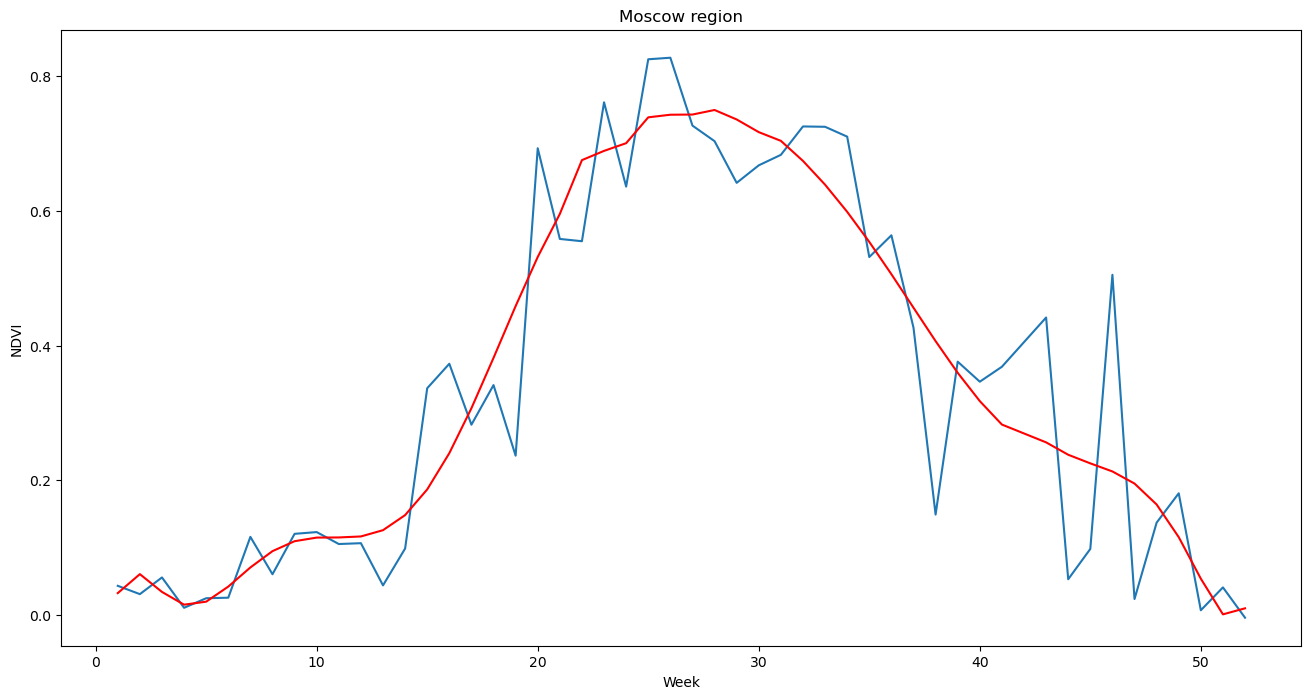

In [15]:
grouped_by_week_msk = moscow_ndvi_df.groupby('Week_Number')['NDVI'].max().reset_index()
#grouped_by_week


plt.figure(figsize=(16,8))
x = grouped_by_week_msk['Week_Number']
y = grouped_by_week_msk['NDVI']
yhat = savgol_filter(y, 42, 10)
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.title('Moscow region')
plt.xlabel('Week')
plt.ylabel('NDVI')


In [16]:
grouped_by_week_msk['NDVI_savgol'] = savgol_filter(grouped_by_week_msk['NDVI'], 42, 10).round(2)

### Sakhalin region

In [17]:
sakhalin_ndvi_df = to_ndvi_df(polygon_sakhalin)
#results plotting

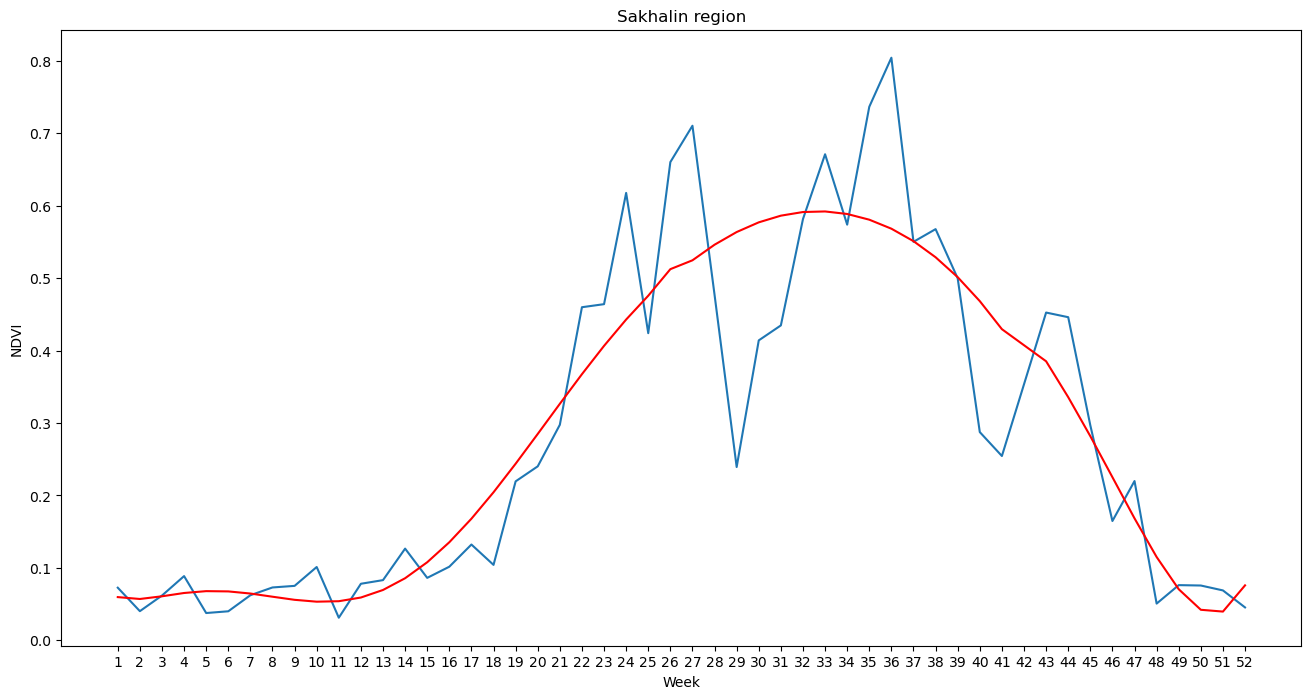

In [18]:
grouped_by_week_sakh = sakhalin_ndvi_df.groupby('Week_Number')['NDVI'].max().reset_index()
#grouped_by_week


plt.figure(figsize=(16,8))
x = grouped_by_week_sakh['Week_Number']
y = grouped_by_week_sakh['NDVI']
yhat = savgol_filter(y, 50, 8)
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.title('Sakhalin region')
plt.xlabel('Week')
plt.ylabel('NDVI')
plt.xticks(np.arange(min(grouped_by_week_sakh.Week_Number), max(grouped_by_week_sakh.Week_Number)+1, 1))
plt.show()

In [19]:
grouped_by_week_sakh['NDVI_savgol'] = savgol_filter(grouped_by_week_sakh['NDVI'], 50, 8)

### Irkutsk region

In [20]:
irkutsk_ndvi_df = to_ndvi_df(polygon_irk)

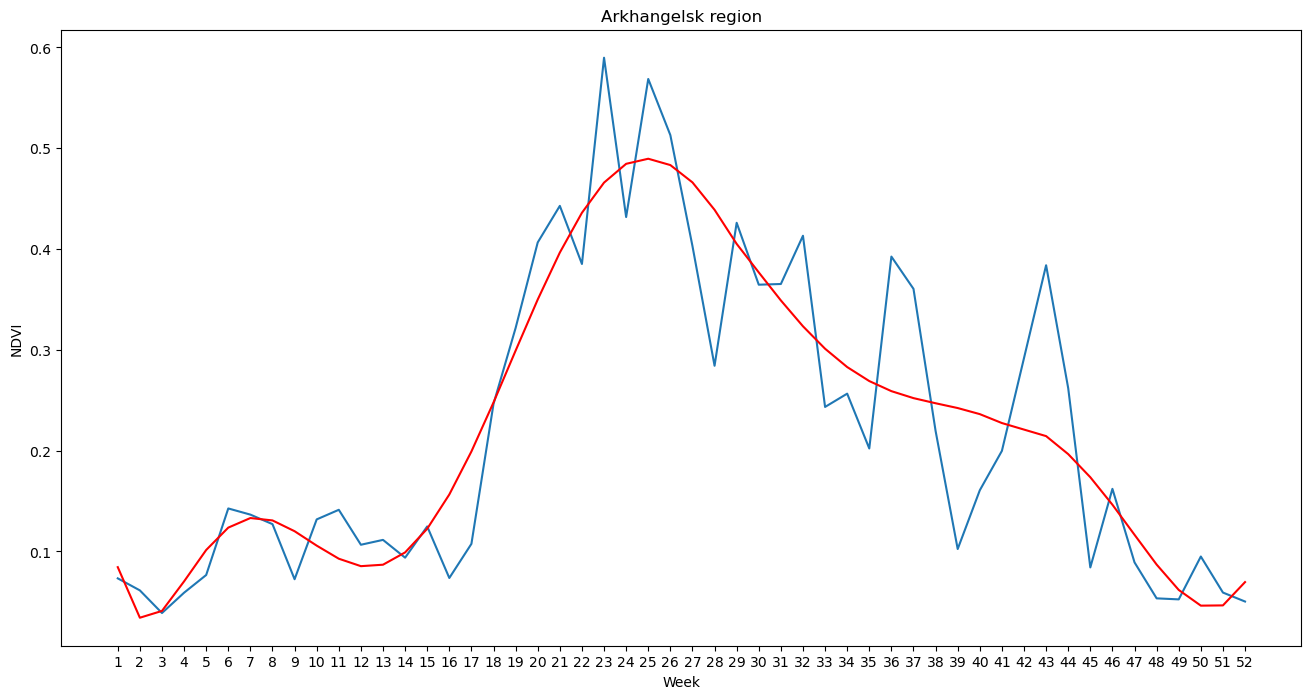

In [21]:
grouped_by_week_irk = irkutsk_ndvi_df.groupby('Week_Number')['NDVI'].max().reset_index()
#grouped_by_week


plt.figure(figsize=(16,8))
x = grouped_by_week_irk['Week_Number']
y = grouped_by_week_irk['NDVI']
yhat = savgol_filter(y, 45, 8)
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.title('Arkhangelsk region')
plt.xlabel('Week')
plt.ylabel('NDVI')
plt.xticks(np.arange(min(grouped_by_week_irk.Week_Number), max(grouped_by_week_irk.Week_Number)+1, 1))
plt.show()

In [22]:
grouped_by_week_irk['NDVI_savgol'] = savgol_filter(grouped_by_week_irk['NDVI'], 45, 8)

### Arkhangelsk region

In [23]:
arkhangelsk_ndvi_df = to_ndvi_df(polygon_arkh_continent)

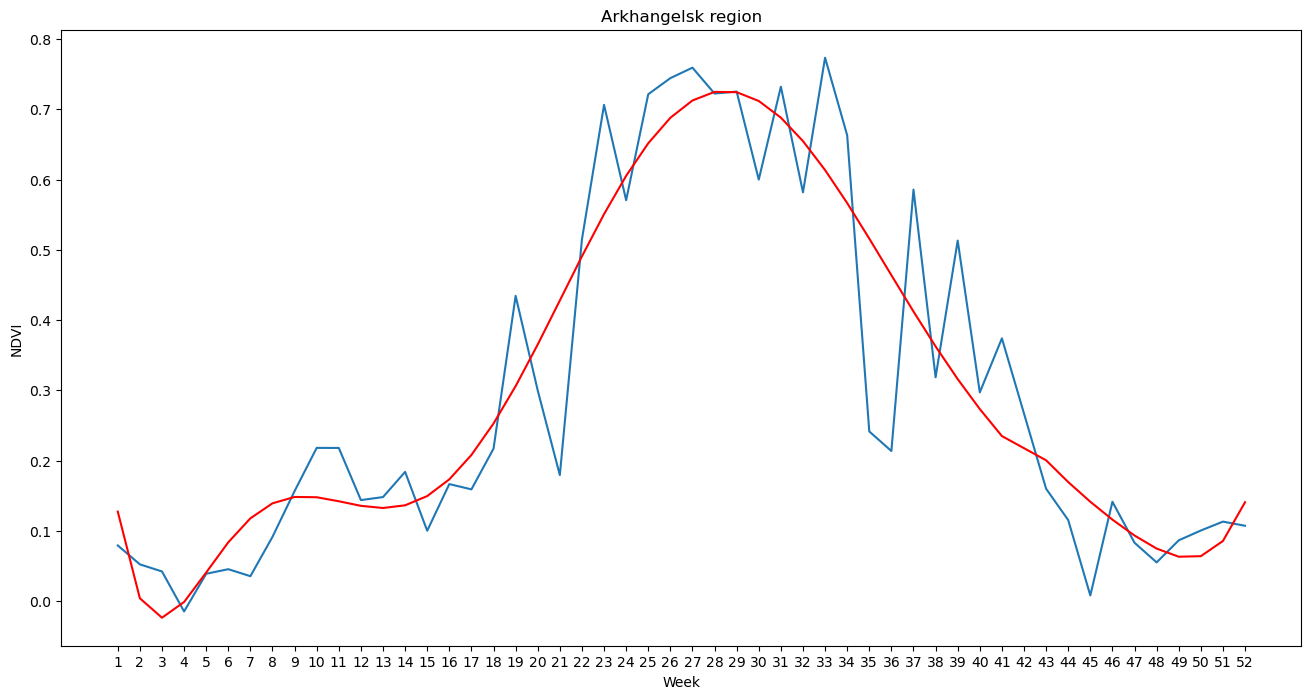

In [24]:
grouped_by_week_ark = arkhangelsk_ndvi_df.groupby('Week_Number')['NDVI'].max().reset_index()
#grouped_by_week


plt.figure(figsize=(16,8))
x = grouped_by_week_ark['Week_Number']
y = grouped_by_week_ark['NDVI']
yhat = savgol_filter(y, 51, 9)
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.title('Arkhangelsk region')
plt.xlabel('Week')
plt.ylabel('NDVI')
plt.xticks(np.arange(min(grouped_by_week_ark.Week_Number), max(grouped_by_week_ark.Week_Number)+1, 1))
plt.show()

In [25]:
grouped_by_week_ark['NDVI_savgol'] = savgol_filter(grouped_by_week_ark['NDVI'], 51, 9)

### Altai region

In [26]:
altai_ndvi_df = to_ndvi_df(polygon_altai)

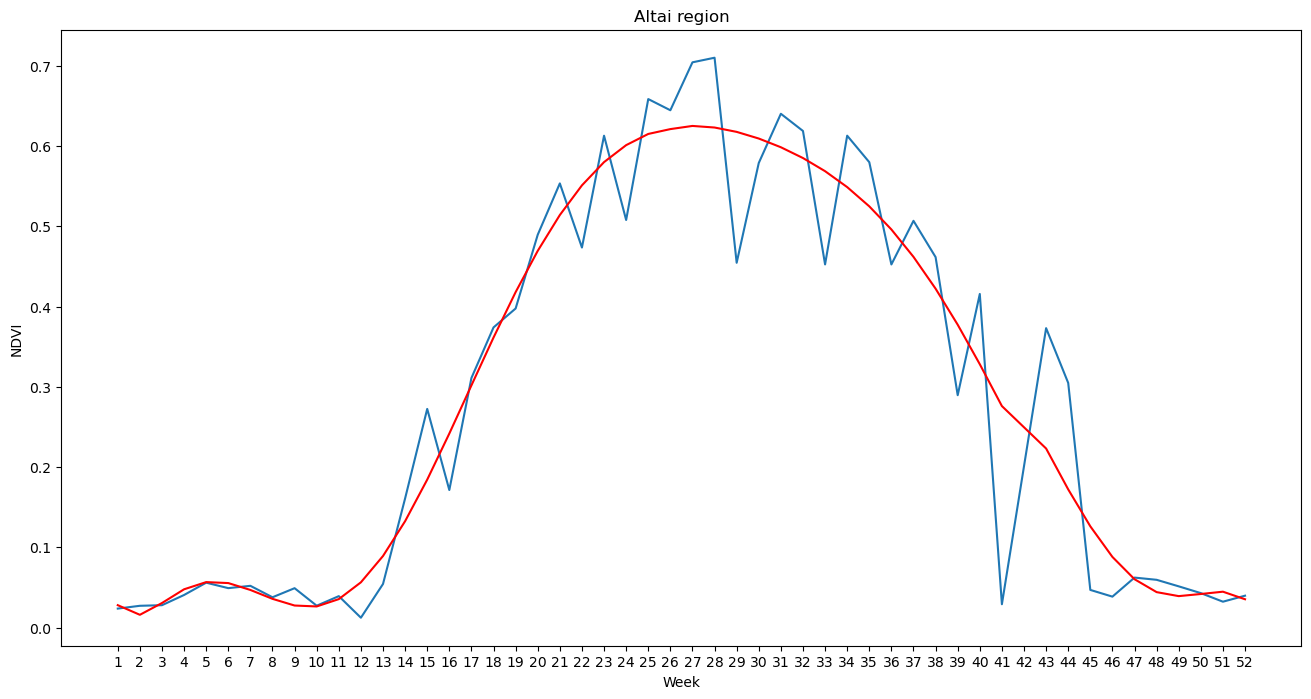

In [27]:
grouped_by_week_al = altai_ndvi_df.groupby('Week_Number')['NDVI'].max().reset_index()
#grouped_by_week

plt.figure(figsize=(16,8))
x = grouped_by_week_al['Week_Number']
y = grouped_by_week_al['NDVI']
yhat = savgol_filter(y, 51, 10)
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.title('Altai region')
plt.xlabel('Week')
plt.ylabel('NDVI')
plt.xticks(np.arange(min(grouped_by_week_al.Week_Number), max(grouped_by_week_al.Week_Number)+1, 1))
plt.show()

In [28]:
grouped_by_week_al['NDVI_savgol'] = savgol_filter(grouped_by_week_al['NDVI'], 51, 10)

## Reports with simple interpolation

For vegetation periods during seasons the following rules can be suggested:
* best summer days: week with interpolated NDVImax, 2 weeks before and 2 weeks after
* best winter days: second half of January and first half of February
* best spring days: week interpolated NDVI > 0.2 but <0.5
* best autumn days: week interpolated NDVI <0.5 but >0.2

boundaries of NDVI are chosen according to the assumption, that NDVI <0.1 corresponds to any forms of water

In [29]:
#report functions
def get_summer_dates(week_df, daily_df):
    idx_summer = week_df.loc[week_df['NDVI_savgol'] == week_df['NDVI_savgol'].max()].index
    filtered_idx_after = (idx_summer+1).union(idx_summer+2)
    filtered_idx_before = (idx_summer-1).union(idx_summer-2)
    target_weeks = filtered_idx_before.append(idx_summer).append(filtered_idx_after)+1
    summer_dates = daily_df.loc[daily_df['Week_Number'].isin(target_weeks)].iloc[[0, -1]].Timestamp.astype(str).tolist()
    return summer_dates

def get_spring_dates(week_df, daily_df):
    target_weeks = week_df.loc[week_df['Week_Number']<=22].loc[(week_df['NDVI_savgol']>0.2)&(week_df['NDVI_savgol']<0.55)]['Week_Number'].tolist()
    spring_dates = daily_df.loc[daily_df['Week_Number'].isin(target_weeks)].iloc[[0, -1]].Timestamp.astype(str).tolist()
    return spring_dates

def get_autumn_dates(week_df, daily_df):
    target_weeks = week_df.loc[week_df['Week_Number']>=35].loc[(week_df['NDVI_savgol']>0.25)&(week_df['NDVI_savgol']<0.55)]['Week_Number'].tolist()
    autumn_dates = daily_df.loc[daily_df['Week_Number'].isin(target_weeks)].iloc[[0, -1]].Timestamp.astype(str).tolist()
    return autumn_dates

def get_winter_dates(daily_df):
    winter_dates = daily_df.loc[daily_df['DOY'].isin(range(15,55))].iloc[[0, -1]].Timestamp.astype(str).tolist()
    return winter_dates

def to_geojson(coords, week_df, daily_df):
    file = {
    'type':'Feature',     
    'properties': {'summer': get_summer_dates(week_df, daily_df),
                   'spring': get_spring_dates(week_df, daily_df),
                   'autumn': get_autumn_dates(week_df, daily_df),
                   'winter': get_winter_dates(daily_df)
    },
    'geometry': {
    'type':'MultiPolygon',
    'coordinates': coords
    } 
    }    
    return file   

In [30]:
moscow_collection = to_geojson(moscow_reg_all_coords, grouped_by_week_msk, moscow_ndvi_df)
sakhalin_collection = to_geojson(sakhalin_all_coords, grouped_by_week_sakh, sakhalin_ndvi_df)
altai_collection = to_geojson(altai_all_coords, grouped_by_week_al, altai_ndvi_df)
irkutsk_collection = to_geojson(irkutsk_all_coords, grouped_by_week_irk, irkutsk_ndvi_df)
arkhangelsk_collection = to_geojson(arkh_all_coords, grouped_by_week_ark, arkhangelsk_ndvi_df)

In [31]:
#with open('moscow_region_dates.geojson', 'w') as f:
#    dump(moscow_collection, f)

#with open('sakhalin_region_dates.geojson', 'w') as f:
#    dump(sakhalin_collection, f)

#with open('altai_region_dates.geojson', 'w') as f:
#    dump(altai_collection, f)
    
#with open('irkutsk_region_dates.geojson', 'w') as f:
#    dump(irkutsk_collection, f)
    
#with open('arkhangelsk_region_dates.geojson', 'w') as f:
#    dump(arkhangelsk_collection, f)

☀️